# Fashion Mnist Classification

Project for IBM AI Engineering certification course.

## Modules

In [1]:
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

from PIL import Image
import time

torch.manual_seed(0)

## Dataset

In [2]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [3]:
IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [4]:
dataset_train = dsets.FashionMNIST(
    root='.fashion/data',
    train=True,
    transform=composed,
    download=True
  )

dataset_val = dsets.FashionMNIST(
    root='.fashion/data',
    train=False,
    transform=composed,
    download=True
  )

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.72MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 145kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.8MB/s]


In [5]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100 )
test_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=100 )

## Models

In [6]:
class CNN_batch(nn.Module):
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)

    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [7]:
class CNN(nn.Module):
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)

    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [8]:
model = CNN(out_1=16, out_2=32,number_of_classes=10)
model_batch =CNN_batch(out_1=16, out_2=32,number_of_classes=10)

## Train

In [9]:
def train(model, optimizer, criterion):
  start_time = time.time()
  cost_list=[]
  accuracy_list=[]
  N_test=len(dataset_val)
  n_epochs=5
  for epoch in range(n_epochs):
      cost=0
      model.train()
      for x, y in train_loader:
          optimizer.zero_grad()
          z = model(x)
          loss = criterion(z, y)
          loss.backward()
          optimizer.step()
          cost+=loss.item()
      correct=0

      model.eval()
      for x_test, y_test in test_loader:
          z = model(x_test)
          _, yhat = torch.max(z.data, 1)
          correct += (yhat == y_test).sum().item()
      accuracy = correct / N_test
      accuracy_list.append(accuracy)
      cost_list.append(cost)

  return cost_list, accuracy_list

In [10]:
cost_list, accuracy_list = train(
  model,
  torch.optim.SGD(model.parameters(), lr=0.1),
  torch.nn.CrossEntropyLoss()
)

In [11]:
cost_list_batch, accuracy_list_batch = train(
  model_batch,
  torch.optim.SGD(model_batch.parameters(), lr=0.1),
  torch.nn.CrossEntropyLoss()
)

In [12]:
def eval_plot(cost_list, accuracy_list, title):
  fig, ax1 = plt.subplots()
  fig.suptitle(title)
  color = 'tab:red'
  ax1.plot(cost_list, color=color)
  ax1.set_xlabel('epoch', color=color)
  ax1.set_ylabel('Cost', color=color)
  ax1.tick_params(axis='y', color=color)

  ax2 = ax1.twinx()
  color = 'tab:blue'
  ax2.set_ylabel('accuracy', color=color)
  ax2.set_xlabel('epoch', color=color)
  ax2.plot( accuracy_list, color=color)
  ax2.tick_params(axis='y', color=color)
  fig.tight_layout()

## Evaluation

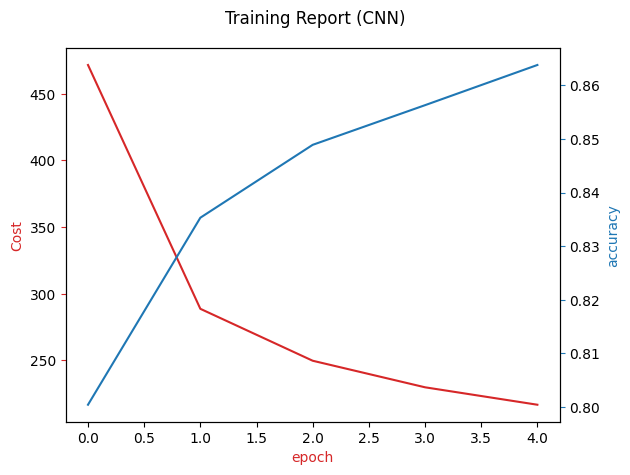

In [13]:
eval_plot(cost_list, accuracy_list, 'Training Report (CNN)')

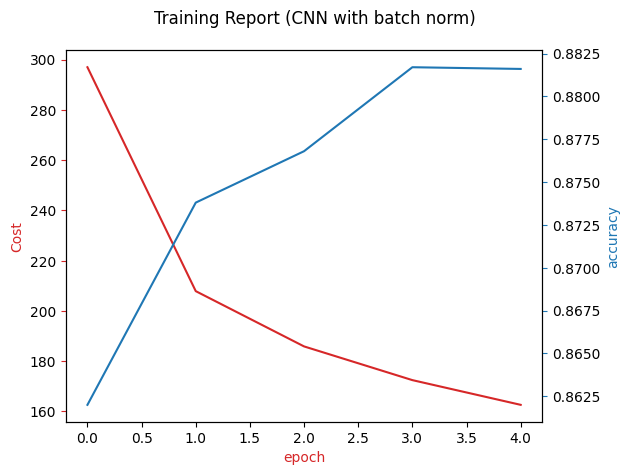

In [14]:
eval_plot(cost_list_batch, accuracy_list_batch, 'Training Report (CNN with batch norm)')